In [1]:
import sys
sys.path.append('../')
import argparse
from dataset.get_dataset import getDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch

class args_struct:
    def __init__(self):
        self.dataroot = '../../data/DiscRegion/DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = False
        self.random_seed = 27
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

In [2]:
import scipy
def get_uncertainty_metrics(predictions, labels, T):
    '''Calculates the uncertainty metrics
    Args:
        predictions: A numpy array of shape (N, C, H, W) or (N, T, C, H, W)
        labels: A numpy array of shape (N, H, W) used to calculate the Negative Log-Likelihood
        T: The number of initial heads to skip in the ensemble to calculate uncertainty
    Returns:
        A dictionary of metrics (Entropy, Mutual Information, Variance, Negative Log-Likelihood)
    '''
    # (N, num_heads, C, H, W)
    num_heads = predictions.shape[1]
    assert T < num_heads, 'SKIP_FIRST_T must be less than the number of heads'
    num_classes = predictions.shape[2]

    # these are uncertainty heatmaps
    entropy_maps = []
    variance_maps = []
    mi_maps = []
    # these are uncertainty metrics for each sample
    entropy_sum = []
    variance_sum = []
    mi_sum = []
    # area under layer agreement curve AULA
    aula_per_class = dict()
    for i in range(1, num_classes):  # ignore background
        aula_per_class[f'aula_{i}'] = []
    # calibration (NLL)
    nlls = []
        
    # convert labels to one hot
    # labels = np.eye(num_classes)[labels.astype(np.uint8)]  # (N, H, W) -> (N, H, W, C)
    # labels = np.transpose(labels, (0, 3, 1, 2))  # (N, H, W, C) -> (N, C, H, W)

    for predicted, label in zip(predictions, labels):
        # softmax along channel axis (NH, C, H, W)
        pred = scipy.special.softmax(predicted[T:, ...], axis=1)
        # average along layer ensemble heads. Keep only the last T heads
        # ([T:], C, H, W) -> (C, H, W)
        avg_pred = np.mean(pred, axis=0)

        # calculate entropy
        entropy = -np.sum(np.mean(pred, axis=0) * np.log(np.mean(pred, axis=0) + 1e-5), axis=0)
        entropy_maps.append(entropy)
        entropy_sum.append(np.sum(entropy))
        
        # calculate variance (after argmax on channel axis)
        variance = np.var(np.argmax(pred, axis=1), axis=0)
        variance_maps.append(variance)
        variance_sum.append(np.sum(variance))

        # calculate mutual information
        expected_entropy = -np.mean(np.sum(pred * np.log(pred + 1e-5), axis=1), axis=0)
        mi = entropy - expected_entropy
        mi_maps.append(mi)
        mi_sum.append(np.sum(mi))

        # calculate negative log-likelihood
        # label (C, H, W); avg_pred (C, H, W)
        nll = -np.mean(np.sum(label * np.log(avg_pred + 1e-5), axis=0))
        nlls.append(nll)
    
    metrics = {
        'entropy': entropy_sum,
        'variance': variance_sum,
        'mi': mi_sum,
        'nll': nlls
    }
    # metrics.update(aula_per_class)
    return metrics, entropy_maps, variance_maps, mi_maps

In [3]:
def get_dice_threshold(output, mask, threshold):
    """
    :param output: output shape per image, float, (0,1)
    :param mask: mask shape per image, float, (0,1)
    :param threshold: the threshold to binarize output and feature (0,1)
    :return: dice of threshold t
    """
    smooth = 1e-6

    zero = torch.zeros_like(output)
    one = torch.ones_like(output)
    output = torch.where(output > threshold, one, zero)
    mask = torch.where(mask > threshold, one, zero)
    output = output.view(-1)
    mask = mask.view(-1)
    intersection = (output * mask).sum()
    dice = (2. * intersection + smooth) / (output.sum() + mask.sum() + smooth)

    return dice
def get_soft_dice(outputs, masks):
    """
    :param outputs: B * output shape per image
    :param masks: B * mask shape per image
    :return: average dice of B items
    """
    dice_list = []
    for this_item in range(outputs.size(0)):
        output = outputs[this_item]
        mask = masks[this_item]
        dice_item_thres_list = []
        for thres in [0.1, 0.3, 0.5, 0.7, 0.9]:
            dice_item_thres = get_dice_threshold(output, mask, thres)
            dice_item_thres_list.append(dice_item_thres.data)
        dice_item_thres_mean = np.mean(dice_item_thres_list)
        dice_list.append(dice_item_thres_mean)

    return np.mean(dice_list)

In [4]:
train_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
disc_dices = []
cup_dices =  []
for batch_data in train_loader:
    imgs, masks, file_names = batch_data['image'], batch_data['mask'], batch_data['name']
    
    patient_disc_dices = []
    patient_cup_dices =  []
    for expert_i in range(len(masks)):
        for expert_j in range(expert_i+1, len(masks)):
            patient_disc_dices.append(
                get_soft_dice(masks[expert_i][:, 0, :, :], masks[expert_j][:, 0, :, :])
            )
            patient_cup_dices.append(
                get_soft_dice(masks[expert_i][:, 1, :, :], masks[expert_j][:, 1, :, :])
            )
    
    disc_dices.append(np.mean(patient_disc_dices))
    cup_dices.append(np.mean(patient_cup_dices))

In [5]:
len(disc_dices)

95

In [6]:
len(cup_dices)

95

In [7]:
np.min(cup_dices)

0.40855427674278527

#### Get model preds

In [5]:
from models.unet_le import UNetLE

In [6]:
class args_struct:
    def __init__(self):
        self.dataroot = '../../data/DiscRegion/DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = True
        self.random_seed = 27
        self.loss_func = 'bce'
        self.batch_size = 1
        self.gt_type_train = -1
        self.num_worker = 4

In [7]:
args = args_struct()

args.gt_type_train = -1
args.loss_func = 'bce' 
args.batch_size = 1
args.num_worker = 4
args.use_mix_label = False
args.standardize = True

In [8]:
from trainer.train_riga_unet_le import validate_riga_le
from loss_func.get_loss import get_loss_func

loss_func = get_loss_func(args)

from models.unet_le import UNetLE
model = UNetLE()

In [9]:
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)

In [146]:
models = {
    'le': {
        'path': '/media/kudaibergen/TS512/projects_ts/grader_soup/src/outputs/RIGA_gt_annots_train_majority_vote_UnetLE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    },
    'our': {
        'path': '/media/kudaibergen/TS512/projects_ts/grader_soup/src/outputs/RIGA_gt_annots_train_majority_vote_UnetLE_LE_w0.3_decoder_heads_only_var_5_lbls_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    }
    } 

for key, value in models.items():
    skip_encoder = False if key == 'le' else True
    model = UNetLE(skip_encoder=skip_encoder)
    model.load_state_dict(torch.load(value['path'])['model'])
    models[key]['model'] = model        

cup_idx = 1
disc_idx = 0

In [101]:
validate_riga_le(args, model, valid_set, loss_func, skip_idx=None)

  0%|          | 0/131 [00:00<?, ?it/s]

100%|██████████| 131/131 [00:03<00:00, 34.06it/s]


(0.5547317323406933, 0.9412534291507634, 0.7726025763358778)

In [13]:
def get_model_outputs(args, model, val_set, loss_function, skip_idx=None, get_logits=False):
    model = model.cuda()
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

    model.eval()

    outputs_model = []
    masks = []
    for step, data in enumerate(val_loader):
        with torch.no_grad():
            imgs = data['image'].cuda()
            mask = data['mask']

            outputs = model({'image': imgs})

            outputs_sigmoid = []
            outputs_raw = []
            if skip_idx is not None:
                outputs = outputs[skip_idx:]

            for i, out in enumerate(outputs):
                out = torch.nn.functional.interpolate(out, size=mask[0].shape[2:])
                if get_logits:
                    outputs_raw.append(out)
                else:
                    outputs_sigmoid.append(torch.sigmoid(out))

        if get_logits:
            outputs_model.append(outputs_raw)
        else:
            outputs_model.append(outputs_sigmoid)
        masks.append(mask)
    return outputs_model, masks

In [ ]:
model_outputs, masks = get_model_outputs(args, model, test_set, loss_func, skip_idx=None, get_logits=True)
model_outputs_np = np.array([torch.stack(out).cpu().numpy() for out in model_outputs])
labels = np.array([torch.stack(mask).mean(axis=0).cpu().numpy() for mask in masks])
u = get_uncertainty_metrics(model_outputs_np[:, :, 0, :, :], labels[:, 0, :, :], T=0)

In [147]:
for i, data in enumerate(models.items()):
    key, val = data
    skip_idx = 3 if key == 'le' else None    
    model_outputs, masks = get_model_outputs(args, val['model'], test_set, loss_func, skip_idx=skip_idx)
    models[key]['outputs'] = (model_outputs)

    outputs_variance_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).sum().cpu().item() for out in model_outputs]
    outputs_variance_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).sum().cpu().item() for out in model_outputs]
    heatmap_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).cpu().numpy() for out in model_outputs]
    heatmap_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).cpu().numpy() for out in model_outputs]

    models[key]['var'] = (outputs_variance_disc, outputs_variance_cup)
    models[key]['heatmap'] = (heatmap_disc, heatmap_cup) 

In [148]:
models['gt'] = {}
models['gt']['outputs'] = masks

mask_variance_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).sum().cpu().item() for out in masks]
mask_variance_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).sum().cpu().item() for out in masks]
mask_heatmap_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).cpu().numpy() for out in masks]
mask_heatmap_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).cpu().numpy() for out in masks]

models['gt']['var'] = (mask_variance_disc, mask_variance_cup)
models['gt']['heatmap'] = (mask_heatmap_disc, mask_heatmap_cup)

In [ ]:
np.var([1, 0, 1])

In [149]:
sorted_indices_disc = np.argsort(models['gt']['var'][disc_idx])[::-1]
sorted_indices_cup = np.argsort(models['gt']['var'][cup_idx])[::-1]

In [124]:
np.sort(models['gt']['var'][disc_idx])

array([ 276.73333333,  303.8       ,  307.9       ,  313.63333333,
        346.46666667,  352.93333333,  373.4       ,  376.        ,
        385.76666667,  388.63333333,  389.2       ,  394.1       ,
        405.6       ,  412.1       ,  413.1       ,  417.3       ,
        423.7       ,  424.36666667,  428.13333333,  435.1       ,
        435.13333333,  435.9       ,  436.53333333,  438.        ,
        438.06666667,  440.73333333,  447.33333333,  450.46666667,
        455.86666667,  465.3       ,  468.26666667,  474.96666667,
        475.66666667,  481.73333333,  484.26666667,  484.73333333,
        486.        ,  493.76666667,  498.83333333,  506.56666667,
        506.9       ,  511.96666667,  516.3       ,  517.        ,
        520.86666667,  523.46666667,  523.9       ,  525.53333333,
        530.5       ,  532.16666667,  536.7       ,  546.83333333,
        548.5       ,  551.16666667,  554.93333333,  557.96666667,
        558.53333333,  569.8       ,  579.83333333,  580.43333

In [131]:
models['le']['var'][disc_idx][sorted_indices_disc[i]]

96.39277648925781

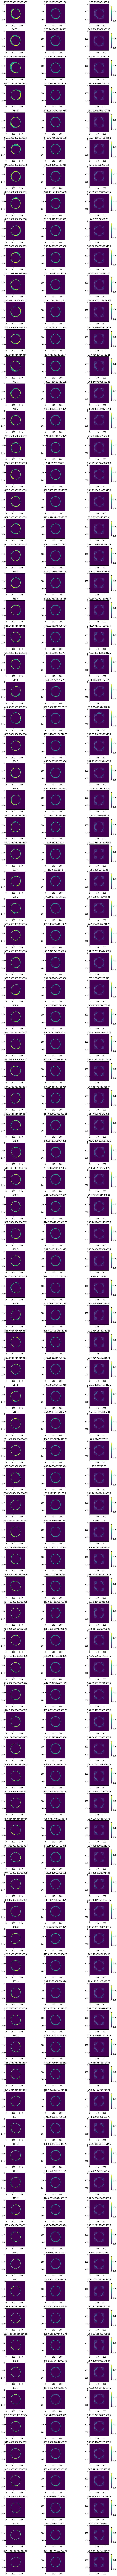

In [150]:
idx = disc_idx
n_rows = len(test_set)
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 200))

axes = axes.flatten()

axis_idx = 0
for i in range(n_rows):
    v_min = np.min([np.min(models['gt']['heatmap'][idx]), np.min(models['our']['heatmap'][idx])])
    v_max = np.max([np.max(models['gt']['heatmap'][idx]), np.max(models['our']['heatmap'][idx])])

    im1 = axes[axis_idx].imshow(models['gt']['heatmap'][idx][sorted_indices_disc[i]][0], vmin=v_min, vmax=v_max)
    axes[axis_idx].set_title(models['gt']['var'][idx][sorted_indices_disc[i]])

    im2 = axes[axis_idx+1].imshow(models['our']['heatmap'][idx][sorted_indices_disc[i]][0], vmin=v_min, vmax=v_max)
    axes[axis_idx+1].set_title(models['our']['var'][idx][sorted_indices_disc[i]])

    im3 = axes[axis_idx+2].imshow(models['le']['heatmap'][idx][sorted_indices_disc[i]][0], vmin=v_min, vmax=v_max)
    axes[axis_idx+2].set_title(models['le']['var'][idx][sorted_indices_disc[i]])
    
    fig.colorbar(im3, shrink=0.8, extend='both')
    axis_idx += n_cols

# fig.subplots_adjust(right=0.85)
# fig.colorbar(im3, shrink=0.5, extend='both')
plt.tight_layout()

In [138]:
len(test_set)

95

In [140]:
len(axes)

240

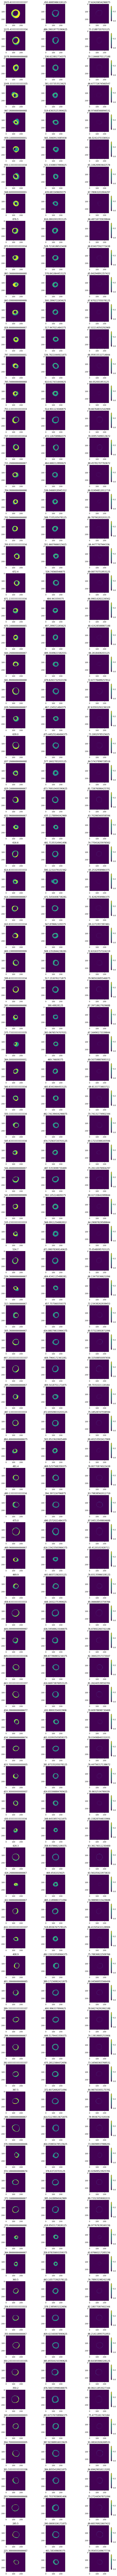

In [143]:
idx = cup_idx
n_rows = len(test_set)
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 200))

axes = axes.flatten()

axis_idx = 0
for i in range(n_rows):
    v_min = np.min([np.min(models['gt']['heatmap'][idx]), np.min(models['our']['heatmap'][idx])])
    v_max = np.max([np.max(models['gt']['heatmap'][idx]), np.max(models['our']['heatmap'][idx])])

    im1 = axes[axis_idx].imshow(models['gt']['heatmap'][idx][sorted_indices_cup[i]][0], vmin=v_min, vmax=v_max)
    axes[axis_idx].set_title(models['gt']['var'][idx][sorted_indices_cup[i]])

    im2 = axes[axis_idx+1].imshow(models['our']['heatmap'][idx][sorted_indices_cup[i]][0], vmin=v_min, vmax=v_max)
    axes[axis_idx+1].set_title(models['our']['var'][idx][sorted_indices_cup[i]])

    im3 = axes[axis_idx+2].imshow(models['le']['heatmap'][idx][sorted_indices_cup[i]][0], vmin=v_min, vmax=v_max)
    axes[axis_idx+2].set_title(models['le']['var'][idx][sorted_indices_cup[i]])
    
    fig.colorbar(im3, shrink=0.8, extend='both')
    axis_idx += n_cols

# fig.subplots_adjust(right=0.85)
# fig.colorbar(im3, shrink=0.5, extend='both')
plt.tight_layout()

#### compare with deep ensembles

In [33]:
checkpoints = [
    f'/home/kudaibergen/projects/grader_soup/outputs/RIGA_gt_annots_train_majority_vote_UnetDE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop{i}/checkpoints/best_loss.pt'
    for i in range(2, 8)
    ]

In [34]:
from models.unet import UNet

In [68]:
models = []
for chk in checkpoints:
    model = UNet()
    model.load_state_dict(torch.load(chk)['model'])
    model.eval()
    model.cuda()
    models.append(model)

In [88]:
val_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

outputs_model = []
for step, data in enumerate(val_loader):
    with torch.no_grad():
        imgs = data['image'].cuda()
        mask = data['mask']

        per_model_outputs = []
        for model in models:
            outputs = model({'image': imgs})
            outputs = torch.sigmoid(outputs['raw'])
            per_model_outputs.append(outputs)

        outputs_model.append(per_model_outputs)

In [89]:
outputs_variance_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).sum().cpu().item() for out in outputs_model]
outputs_variance_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).sum().cpu().item() for out in outputs_model]

In [38]:
len(outputs_variance_cup)

95

In [71]:
pearsonr(disc_dices, outputs_variance_disc), \
pearsonr(cup_dices, outputs_variance_cup), \
pearsonr(mak_variance_disc, outputs_variance_disc), \
pearsonr(mask_variance_cup, outputs_variance_cup)

(PearsonRResult(statistic=0.007808024585446924, pvalue=0.9401376382040015),
 PearsonRResult(statistic=0.13238158794289617, pvalue=0.20094933500470727),
 PearsonRResult(statistic=0.33620687057197585, pvalue=0.000865085161279506),
 PearsonRResult(statistic=0.41210534757331957, pvalue=3.332062739050576e-05))

In [70]:
spearmanr(disc_dices, outputs_variance_disc), \
spearmanr(cup_dices, outputs_variance_cup), \
spearmanr(mak_variance_disc, outputs_variance_disc), \
spearmanr(mask_variance_cup, outputs_variance_cup)

(SignificanceResult(statistic=-0.08332866741321389, pvalue=0.42207123315036565),
 SignificanceResult(statistic=0.11444568868980963, pvalue=0.26944362467864685),
 SignificanceResult(statistic=0.4728723404255319, pvalue=1.30585103498037e-06),
 SignificanceResult(statistic=0.349426091825308, pvalue=0.0005189462989888927))

In [90]:
distance_correlation(disc_dices, outputs_variance_disc), \
distance_correlation(cup_dices, outputs_variance_cup), \
distance_correlation(mak_variance_disc, outputs_variance_disc), \
distance_correlation(mask_variance_cup, outputs_variance_cup)

(0.188117568070703, 0.1729388158702675, 0.4440356044219752, 0.3995507343316547)